<a href="https://colab.research.google.com/github/dasparagjyoti/EEG-Channel-Selection-for-Emotion-Recognition/blob/main/Participant_1%2C_80_20split%2CValence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Data Preprocessing**#

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
import pickle  
drive._mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/data_preprocessed_python/s01.dat', 'rb') as f:
 raw_data = pickle.load(f, encoding='latin1')

In [ ]:
!pip install skfeature-chappers

     |████████████████████████████████| 66 kB 2.3 MB/s 


In [ ]:
import numpy as np
from scipy.sparse import diags
from skfeature.function.similarity_based import fisher_score
from skfeature.utility.construct_W import construct_W

def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature
    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

In [ ]:
data = raw_data['data']
labels = raw_data['labels']

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (40, 4)
Data:  (40, 40, 8064)


In [ ]:
"""
em_labels = []
for i in range(0, labels.shape[0]):
	if (labels[i][0]>5): #high valence
		if(labels[i][1]>5): # high arousal
			em_labels.append(1) # HVHA
		else:
			em_labels.append(0) # HVLA
	else: # low valence
		if(labels[i][1]>5): # high arousal
			em_labels.append(2) #LVHA
		else:
			em_labels.append(3) # LVLA
"""
em_labels = []
for i in range(0, labels.shape[0]):
	if (labels[i][0]>5): #high valence
			em_labels.append(0) # HVHA
	else: # low valence
			em_labels.append(1)

In [ ]:
print(em_labels)

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


# Fisher's Score for Theta Band

In [ ]:
# load dataset
data_theta = pd.read_csv('/content/1df_theta.csv')
# features from all the channels from the theta band only
data_theta.shape
data_theta['videos'] = em_labels
data_theta['videos'].unique()
X = data_theta[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_theta['videos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_theta = fisher_score(X_train, y_train)

# Fisher Score for Alpha Band

In [ ]:
# load dataset
data_alpha = pd.read_csv('/content/2df_alpha.csv')
# features from all the channels from the theta band only
data_alpha.shape
data_alpha['videos'] = em_labels
data_alpha['videos'].unique()
X = data_alpha[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_alpha['videos']
y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_alpha = fisher_score(X_train, y_train)

# Fisher Score for Beta Band

In [ ]:
# load dataset
data_beta = pd.read_csv('/content/3df_beta.csv')
# features from all the channels from the theta band only
data_beta.shape
data_beta['videos'] = em_labels
data_beta['videos'].unique()
X = data_beta[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_beta['videos']
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_beta = fisher_score(X_train, y_train)

# Fisher Score for Gamma Band

In [ ]:
# load dataset
data_gamma = pd.read_csv('/content/4df_gamma.csv')
# features from all the channels from the theta band only
data_gamma.shape
data_gamma['videos'] = em_labels
data_gamma['videos'].unique()
X = data_gamma[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_gamma['videos']
y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_gamma = fisher_score(X_train, y_train)

# Total Avearge F-Score(Theta,Alpha,Beta,Gamma)

In [ ]:
final_f_score = (f_score_theta + f_score_alpha + f_score_beta + f_score_gamma)/4

In [ ]:
fvalues = pd.Series(final_f_score)
X_train = pd.DataFrame(X_train)
fvalues.index = X.columns
fvalues.sort_values(ascending=False)
fvalues.to_csv('fscore_final.csv')
print(fvalues)

Fp1    0.001774
AF3    0.005493
F3     0.003601
F7     0.006026
FC5    0.010173
FC1    0.007053
C3     0.019712
T7     0.020898
CP5    0.014118
CP1    0.007893
P3     0.007443
P7     0.018133
PO3    0.001538
O1     0.002034
Oz     0.000358
Pz     0.005698
Fp2    0.007796
AF4    0.016211
Fz     0.055144
F4     0.025343
F8     0.005955
FC6    0.010683
FC2    0.052024
Cz     0.002295
C4     0.029237
T8     0.017139
CP6    0.024783
CP2    0.007043
P4     0.013315
P8     0.004628
PO4    0.008457
O2     0.002314
dtype: float64


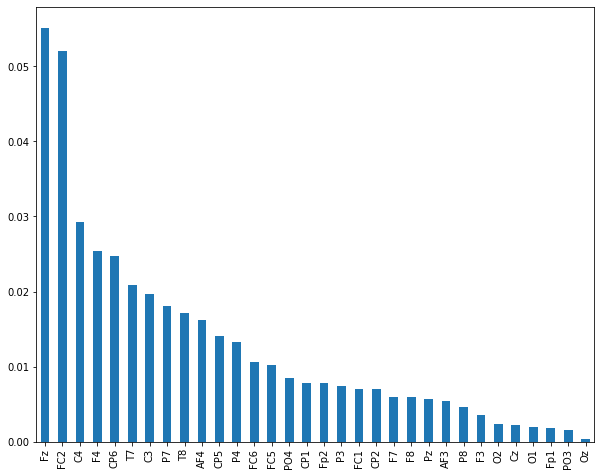

In [ ]:
fvalues.sort_values(ascending = False).plot.bar(figsize=(10,8))

# Classification

##Taking 'Fz' Feature(Highest Score)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
all_data = pd.read_csv("/content/7AllMerged.csv")
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma"]]
y = np.array(em_labels)

In [ ]:
feature_name = all_data.columns
feature_name = np.array(feature_name)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [ ]:
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train, y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.6875
Accuracy on test data :  0.75


##Taking Fz and Fc2 Feature

In [ ]:
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"]]
y = np.array(em_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train,y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.6875
Accuracy on test data :  0.75


##Taking Fz and Fc2, F4 Feature

In [ ]:
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma", "F4Theta","F4Alpha","F4Beta","F4Gamma"]]
y = np.array(em_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train,y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.65625
Accuracy on test data :  0.875


##Taking Fz and Fc2, F4, CP6 Feature

In [ ]:
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma",\
          "F4Theta","F4Alpha","F4Beta","F4Gamma", "CP6Theta","CP6Alpha","CP6Beta","CP6Gamma"]]
y = np.array(em_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train,y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.65625
Accuracy on test data :  0.875


##Taking Fz and Fc2, F4, CP6, AF4 Feature

In [ ]:
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
          ,"F4Theta","F4Alpha","F4Beta","F4Gamma", "CP6Theta","CP6Alpha","CP6Beta","CP6Gamma"\
          ,"AF4Theta","AF4Alpha","AF4Beta","AF4Gamma"]]
y = np.array(em_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train,y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.625
Accuracy on test data :  0.875


##Taking Fz and Fc2, F4, CP6, AF4, CP1 Feature

In [ ]:
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
          ,"F4Theta","F4Alpha","F4Beta","F4Gamma", "CP6Theta","CP6Alpha","CP6Beta","CP6Gamma"\
          ,"AF4Theta","AF4Alpha","AF4Beta","AF4Gamma", "CP1Theta","CP1Alpha","CP1Beta","CP1Gamma"]]
y = np.array(em_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train,y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.65625
Accuracy on test data :  0.875


##Taking Fz and Fc2, F4, CP6, AF4, CP1, FC1 Feature

In [ ]:
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
          ,"F4Theta","F4Alpha","F4Beta","F4Gamma", "CP6Theta","CP6Alpha","CP6Beta","CP6Gamma"\
          ,"AF4Theta","AF4Alpha","AF4Beta","AF4Gamma", "CP1Theta","CP1Alpha","CP1Beta","CP1Gamma",
          "FC1Theta","FC1Alpha","FC1Beta","FC1Gamma"]]
y = np.array(em_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train,y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.65625
Accuracy on test data :  0.875


##Taking Fz and Fc2, F4, CP6, AF4, CP1, FC1, CP2 Feature

In [ ]:
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
          ,"F4Theta","F4Alpha","F4Beta","F4Gamma", "CP6Theta","CP6Alpha","CP6Beta","CP6Gamma"\
          ,"AF4Theta","AF4Alpha","AF4Beta","AF4Gamma", "CP1Theta","CP1Alpha","CP1Beta","CP1Gamma",
          "FC1Theta","FC1Alpha","FC1Beta","FC1Gamma", "CP2Theta","CP2Alpha","CP2Beta","CP2Gamma"]]
y = np.array(em_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train,y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.65625
Accuracy on test data :  0.875


In [ ]:
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
          ,"F4Theta","F4Alpha","F4Beta","F4Gamma", "CP6Theta","CP6Alpha","CP6Beta","CP6Gamma"\
          ,"AF4Theta","AF4Alpha","AF4Beta","AF4Gamma", "CP1Theta","CP1Alpha","CP1Beta","CP1Gamma"\
          ,"FC1Theta","FC1Alpha","FC1Beta","FC1Gamma", "CP2Theta","CP2Alpha","CP2Beta","CP2Gamma"]]
y = np.array(em_labels)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
classifier = svm.SVC(kernel='poly')
classifier.fit(x_train,y_train)
x_train_prediction = classifier.predict(x_train)
training_data_accuray = accuracy_score(x_train_prediction,y_train)
print('Accuracy on training data : ', training_data_accuray)
x_test_prediction = classifier.predict(x_test)
test_data_accuray = accuracy_score(x_test_prediction,y_test)
print('Accuracy on test data : ', test_data_accuray)

Accuracy on training data :  0.65625
Accuracy on test data :  0.875


#**1. Data Preprocessing**#

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
import pickle  
drive._mount('/content/drive')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/data_preprocessed_python/s01.dat', 'rb') as f:
 raw_data = pickle.load(f, encoding='latin1')

In [ ]:
pip install skfeature-chappers

     |████████████████████████████████| 66 kB 2.6 MB/s 


In [ ]:
import numpy as np
from skfeature.utility.construct_W import construct_W
from scipy.sparse import diags

def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature
    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

In [ ]:
data = raw_data['data']
labels = raw_data['labels']

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (40, 4)
Data:  (40, 40, 8064)


In [ ]:
"""
em_labels = []
for i in range(0, labels.shape[0]):
	if (labels[i][0]>5): #high valence
		if(labels[i][1]>5): # high arousal
			em_labels.append(1) # HVHA
		else:
			em_labels.append(0) # HVLA
	else: # low valence
		if(labels[i][1]>5): # high arousal
			em_labels.append(2) #LVHA
		else:
			em_labels.append(3) # LVLA
"""
em_labels = []
for i in range(0, labels.shape[0]):
	if (labels[i][0]>5): #high arousal
			em_labels.append(0) # HVHA
	else: # low arousal
			em_labels.append(1)

In [ ]:
print(em_labels)

[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


# Fisher's Score for Theta Band

In [ ]:
# load dataset
data_theta = pd.read_csv('/1df_theta.csv')
# features from all the channels from the theta band only
data_theta.shape
data_theta['videos'] = em_labels
data_theta['videos'].unique()
X = data_theta[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_theta['videos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_theta = fisher_score(X_train, y_train)

# Fisher Score for Alpha Band

In [ ]:
# load dataset
data_alpha = pd.read_csv('/2df_alpha.csv')
# features from all the channels from the theta band only
data_alpha.shape
data_alpha['videos'] = em_labels
data_alpha['videos'].unique()
X = data_alpha[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_alpha['videos']
y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_alpha = fisher_score(X_train, y_train)

# Fisher Score for Beta Band

In [ ]:
# load dataset
data_beta = pd.read_csv('/3df_beta.csv')
# features from all the channels from the theta band only
data_beta.shape
data_beta['videos'] = em_labels
data_beta['videos'].unique()
X = data_beta[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_beta['videos']
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_beta = fisher_score(X_train, y_train)

# Fisher Score for Gamma Band

In [ ]:
# load dataset
data_gamma = pd.read_csv('/4df_gamma.csv')
# features from all the channels from the theta band only
data_gamma.shape
data_gamma['videos'] = em_labels
data_gamma['videos'].unique()
X = data_gamma[['Fp1',	'AF3',	'F3',	'F7',	'FC5',	'FC1',	'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'Oz',	'Pz',	'Fp2',	'AF4',	'Fz',	'F4',	'F8',	'FC6',	'FC2',	'Cz',	'C4',	'T8',	'CP6',	'CP2',	'P4',	'P8',	'PO4',	'O2']]
# taking only first 32 channels (EEG signals)
y = data_gamma['videos']
y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train = np.array(X_train)
y_train = np.array(y_train)
f_score_gamma = fisher_score(X_train, y_train)

# Total Avearge F-Score(Theta,Alpha,Beta,Gamma)

In [ ]:
final_f_score = (f_score_theta + f_score_alpha + f_score_beta + f_score_gamma)/4

In [ ]:
fvalues = pd.Series(final_f_score)
X_train = pd.DataFrame(X_train)
fvalues.index = X.columns
fvalues.sort_values(ascending=False)
fvalues.to_csv('fscore_final.csv')
print(fvalues)

Fp1    0.001774
AF3    0.005493
F3     0.003601
F7     0.006026
FC5    0.010173
FC1    0.007053
C3     0.019712
T7     0.020898
CP5    0.014118
CP1    0.007893
P3     0.007443
P7     0.018133
PO3    0.001538
O1     0.002034
Oz     0.000358
Pz     0.005698
Fp2    0.007796
AF4    0.016211
Fz     0.055144
F4     0.025343
F8     0.005955
FC6    0.010683
FC2    0.052024
Cz     0.002295
C4     0.029237
T8     0.017139
CP6    0.024783
CP2    0.007043
P4     0.013315
P8     0.004628
PO4    0.008457
O2     0.002314
dtype: float64


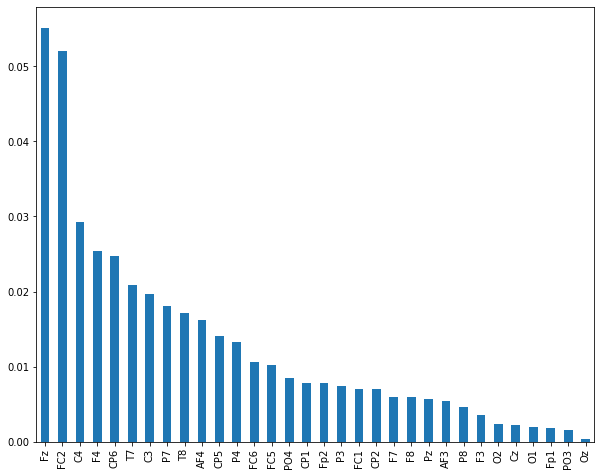

In [ ]:
fvalues.sort_values(ascending = False).plot.bar(figsize=(10,8))

In [ ]:
shyam = fvalues.sort_values(ascending = False)
da = pd.DataFrame(shyam)
da.to_csv("channel_rank.csv")
cr = pd.read_csv("channel_rank.csv")
list(cr["Unnamed: 0"])

['Fz',
 'FC2',
 'C4',
 'F4',
 'CP6',
 'T7',
 'C3',
 'P7',
 'T8',
 'AF4',
 'CP5',
 'P4',
 'FC6',
 'FC5',
 'PO4',
 'CP1',
 'Fp2',
 'P3',
 'FC1',
 'CP2',
 'F7',
 'F8',
 'Pz',
 'AF3',
 'P8',
 'F3',
 'O2',
 'Cz',
 'O1',
 'Fp1',
 'PO3',
 'Oz']

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
all_data = pd.read_csv("/7AllMerged.csv")
data = all_data.drop('videos', axis = 1)

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Loading the dataset
def svmclassifier(channel_name):
  channel_names = []
  for i in range(0, len(channel_name)):
    draft = channel_name[i]
    channel_names.append(draft + "Alpha")
    channel_names.append(draft + "Beta")
    channel_names.append(draft + "Gamma")
    channel_names.append(draft + "Theta")
  x = data[channel_names]
  y = np.array(em_labels)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
  classifier = svm.SVC(kernel = 'poly')
  classifier.fit(x_train, y_train)
  x_train_prediction = classifier.predict(x_train)
  training_data_accuray = accuracy_score(x_train_prediction, y_train)
  print('Accuracy on training data : ', training_data_accuray)
  x_test_prediction = classifier.predict(x_test)
  test_data_accuray = accuracy_score(x_test_prediction, y_test)
  print('Accuracy on test data : ', test_data_accuray)

In [ ]:
svmclassifier(["Fz"]) #'FC2','C4','F4','CP6','T7','C3','P7','T8','AF4','CP5','P4','FC6','FC5','PO4','CP1','Fp2','P3','FC1','CP2','F7','F8','Pz','AF3','P8','F3','O2','Cz','O1','Fp1','PO3','Oz'

Accuracy on training data :  0.6875
Accuracy on test data :  0.75


In [ ]:
svmclassifier(["Fz","FC2","F4","CP6","AF4","CP1","FC1","CP2","PO3"]) 

Accuracy on training data :  0.71875
Accuracy on test data :  0.875


#EXTRA TEST FOR OTHER CLASSIFIERS

In [ ]:
#Loading the dataset
data = all_data.drop('videos', axis = 1)
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma"]]
"""
x = data[["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
          ,"F4Theta","F4Alpha","F4Beta","F4Gamma", "CP6Theta","CP6Alpha","CP6Beta","CP6Gamma"\
          ,"AF4Theta","AF4Alpha","AF4Beta","AF4Gamma", "CP1Theta","CP1Alpha","CP1Beta","CP1Gamma"\
          ,"FC1Theta","FC1Alpha","FC1Beta","FC1Gamma", "CP2Theta","CP2Alpha","CP2Beta","CP2Gamma"]]
"""
y = np.array(em_labels)

#Implementing cross validation
from sklearn.model_selection import KFold
k = 10
kf = KFold(n_splits=k, random_state=None)
#model = LogisticRegression(solver= 'liblinear')
model = svm.SVC(kernel='poly')

acc_score = []

for train_index , test_index in kf.split(x):
    x_train , x_test = x.iloc[train_index,:],x.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    model.fit(x_train,y_train)
    pred_values = model.predict(x_test)
    
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
    
avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [1.0, 0.75, 0.25, 0.5, 0.75, 0.75, 0.0, 0.25, 0.5, 0.5]
Avg accuracy : 0.525


In [ ]:
#Importing required libraries
#from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Loading the dataset
def mlpclassifier(mystr):
  data = all_data.drop('videos', axis = 1)
  #x = data[["FzTheta","FzAlpha","FzBeta","FzGamma"]]
  x = data[mystr]
  y = np.array(em_labels)

  #Implementing cross validation

  k = 10
  kf = KFold(n_splits=k, random_state=None)
  model = MLPClassifier(alpha=1e-5,hidden_layer_sizes=(100, ), random_state=1)
 
  acc_score = []

  for train_index , test_index in kf.split(x):
      x_train , x_test = x.iloc[train_index,:],x.iloc[test_index,:]
      y_train , y_test = y[train_index] , y[test_index]
    
      model.fit(x_train,y_train)
      pred_values = model.predict(x_test)
      #print("Train accuracy: ", )
    
      acc = accuracy_score(pred_values , y_test)
      acc_score.append(acc)
    
  avg_acc_score = sum(acc_score)/k

  print('accuracy of each fold - {}'.format(acc_score))
  print('Avg accuracy : {}'.format(avg_acc_score))

In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma"])

accuracy of each fold - [0.5, 0.75, 0.5, 0.5, 0.75, 0.0, 0.0, 0.5, 0.75, 0.5]
Avg accuracy : 0.475


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"])

accuracy of each fold - [0.25, 0.0, 1.0, 0.75, 0.25, 0.0, 0.25, 0.75, 1.0, 0.75]
Avg accuracy : 0.5


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma", "F4Theta","F4Alpha","F4Beta","F4Gamma"])

accuracy of each fold - [0.5, 0.75, 0.5, 0.5, 0.75, 1.0, 0.25, 0.5, 0.75, 0.5]
Avg accuracy : 0.6


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"F4Theta","F4Alpha","F4Beta","F4Gamma"])

accuracy of each fold - [0.5, 0.75, 0.5, 0.5, 0.75, 1.0, 0.25, 0.5, 0.75, 0.5]
Avg accuracy : 0.6


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma"])

accuracy of each fold - [0.5, 0.75, 0.5, 0.75, 0.75, 1.0, 0.0, 0.5, 0.75, 0.5]
Avg accuracy : 0.6


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","F4Theta","F4Alpha","F4Beta","F4Gamma"])

accuracy of each fold - [0.25, 0.75, 0.5, 0.5, 0.5, 1.0, 0.0, 0.25, 0.25, 0.5]
Avg accuracy : 0.45


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","CP6Theta","CP6Alpha","CP6Beta","CP6Gamma"])

accuracy of each fold - [0.5, 0.75, 0.25, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.25]
Avg accuracy : 0.325


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","T7Theta","T7Alpha","T7Beta","T7Gamma"])

accuracy of each fold - [0.5, 0.25, 0.5, 0.75, 0.75, 1.0, 0.0, 0.5, 0.25, 0.5]
Avg accuracy : 0.5


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","T7Theta","T7Alpha","T7Beta","T7Gamma"\
               ,"P7Theta","P7Alpha","P7Beta","P7Gamma"])

accuracy of each fold - [0.5, 0.0, 0.5, 0.75, 1.0, 0.0, 0.0, 0.5, 0.75, 0.5]
Avg accuracy : 0.45


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","T7Theta","T7Alpha","T7Beta","T7Gamma"\
               ,"T8Theta","T8Alpha","T8Beta","T8Gamma"])

accuracy of each fold - [0.25, 0.75, 0.5, 0.75, 0.75, 0.0, 0.0, 0.5, 0.75, 0.5]
Avg accuracy : 0.475


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","T7Theta","T7Alpha","T7Beta","T7Gamma"\
               ,"P4Theta","P4Alpha","P4Beta","P4Gamma"])

accuracy of each fold - [0.5, 0.75, 0.5, 0.75, 1.0, 0.75, 0.0, 0.5, 0.75, 0.5]
Avg accuracy : 0.6


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","T7Theta","T7Alpha","T7Beta","T7Gamma"\
               ,"P4Theta","P4Alpha","P4Beta","P4Gamma","FC6Theta","FC6Alpha","FC6Beta","FC6Gamma"])

accuracy of each fold - [0.25, 0.0, 0.5, 0.75, 0.5, 0.0, 0.25, 0.5, 0.75, 0.5]
Avg accuracy : 0.4


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","T7Theta","T7Alpha","T7Beta","T7Gamma"\
               ,"P4Theta","P4Alpha","P4Beta","P4Gamma","FC5Theta","FC5Alpha","FC5Beta","FC5Gamma"])

accuracy of each fold - [0.25, 0.0, 0.5, 0.75, 0.5, 0.0, 0.0, 0.5, 0.75, 0.5]
Avg accuracy : 0.375


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","T7Theta","T7Alpha","T7Beta","T7Gamma"\
               ,"P4Theta","P4Alpha","P4Beta","P4Gamma","PO4Theta","PO4Alpha","PO4Beta","PO4Gamma"])

accuracy of each fold - [0.5, 0.0, 0.5, 0.75, 0.75, 0.25, 0.0, 0.5, 0.75, 0.5]
Avg accuracy : 0.45


In [ ]:
mlpclassifier(["FzTheta","FzAlpha","FzBeta","FzGamma", "FC2Theta","FC2Alpha","FC2Beta","FC2Gamma"\
              ,"C4Theta","C4Alpha","C4Beta","C4Gamma","T7Theta","T7Alpha","T7Beta","T7Gamma"\
               ,"P4Theta","P4Alpha","P4Beta","P4Gamma","CP1Theta","CP1Alpha","CP1Beta","CP1Gamma"])

accuracy of each fold - [0.25, 0.0, 0.5, 0.75, 0.5, 0.0, 0.25, 0.5, 0.75, 0.5]
Avg accuracy : 0.4
